In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('HeatExchanger_Data.xlsx').values
data = data[:, 1:]
mfg = data[:, 0]
msteam = data[:, 1]
Tfgin = data[:, 2]
Tsteamin = data[:, 3]
Tfgout = data[:, 4]
Tsteamout = data[:, 5]
Ttube = data[:, 6]
tt = data.shape[0]  # Total data
tn = int(0.6 * tt)  # Total Number of Training Data
tv = tt - tn  # Total Number of Validation Data
nt = 7  # Total number of variables
ni = 4  # Number of neurons in Input Layer
no = 3  # Number of neurons in Output Layer

In [3]:
norm_mat = np.zeros((tt, nt))
delta = np.zeros(nt)
for i in range(nt):
    delta[i] = np.max(data[:, i]) - np.min(data[:, i])
    norm_mat[:, i] = (data[:, i] - np.min(data[:, i])) / delta[i]  # Max-Min Normalization
    
dsr = norm_mat[:, 4:7].T  # Target array
Imat = np.concatenate((norm_mat[:, 2:4], norm_mat[:, 0:2]), axis=1).T  # Input array

tr_steps = np.random.choice(tt, tn, replace=False)
tr_steps = np.sort(tr_steps)
dsr_t = np.zeros((no, tn))
Imat_t = np.zeros((ni, tn))
for i in range(tn):
    ts = tr_steps[i]
    dsr_t[:, i] = dsr[:, ts]          # Training Output: dsr_t 
    Imat_t[:, i] = Imat[:, ts]        # Training Input: Imat_t 

val_steps = np.setdiff1d(np.arange(tt), tr_steps)
dsr_v = np.zeros((no, tv))
Imat_v = np.zeros((ni, tv))

for i in range(tv):
    ts = val_steps[i]
    dsr_v[:, i] = dsr[:, ts]
    Imat_v[:, i] = Imat[:, ts]    

In [14]:
# Number of centers of RBFs
tc = 5

# Getting coordinates of the centres
distances = np.zeros(len(Imat_t[1]))
mean1=np.mean(Imat_t[:,0])
mean2=np.mean(Imat_t[:,1])
mean3=np.mean(Imat_t[:,2])
mean4=np.mean(Imat_t[:,3])
mean = np.array([mean1, mean2, mean3, mean4])
for i in range(len(Imat_t)):
    for j in range(ni):
        distances[i]+=Imat_t[j][i]-mean[j]
indices = np.argsort(distances)   # Sorting the distances and get corresponding indices
# for l in range(tc):
#     centermat=Imat_t[indices[l]]
centermat = Imat_t[:,indices[:tc]]   # Select 'tc'-nearest neighbors as the centres

#Getting width
#sigma = 2
kmeans = KMeans(n_clusters=tc)
kmeans.fit(Imat_t.T)
centers = kmeans.cluster_centers_.T
sigma = np.mean(np.linalg.norm(centermat - centers, axis=0))

#Getting Weights by Least Square method
D = np.zeros((tc, tn))
for i in range(tc):
    for j in range(tn):
        D[i, j] = np.linalg.norm(centermat[:, i] - Imat_t[:, j])
PhiofD = 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-D**2 / (2 * sigma**2))  
z = np.linalg.pinv(PhiofD.T) @ dsr_t.T

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#Training

In [15]:
D = np.zeros((tc, tn))
for i in range(tc):
    for j in range(tn):
        D[i, j] = np.linalg.norm(centermat[:, i] - Imat_t[:, j])
yHL = 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-D**2 / (2 * sigma**2))
ynn_tv = np.dot(yHL.T, z)  # Prediction of Training Data
dsr_t_v = dsr_t.T*delta[ni:] + np.min(data[:, ni:], axis=0)
ynn_t_v = ynn_tv*delta[ni:] + np.min(data[:, ni:], axis=0)

In [16]:
yHL.shape

(5, 360)

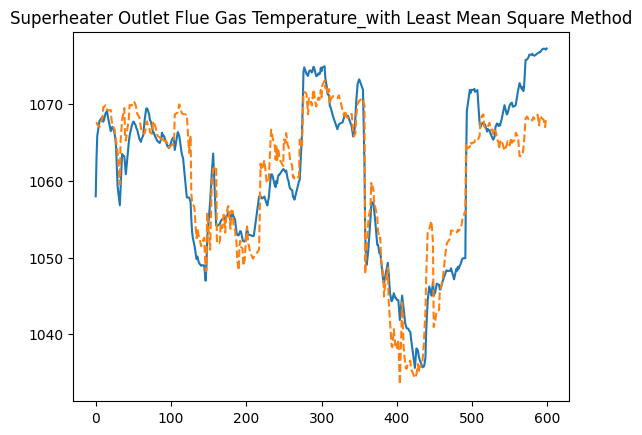

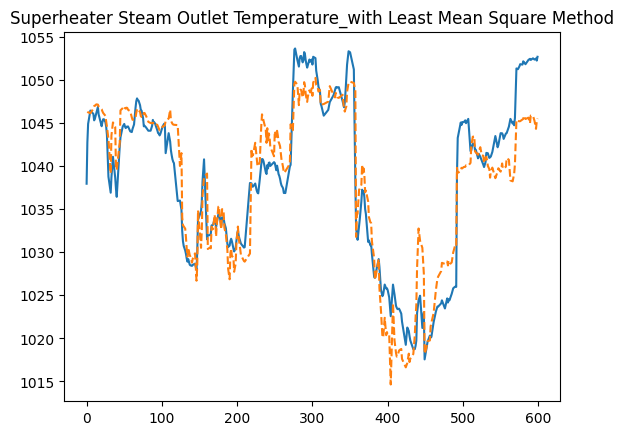

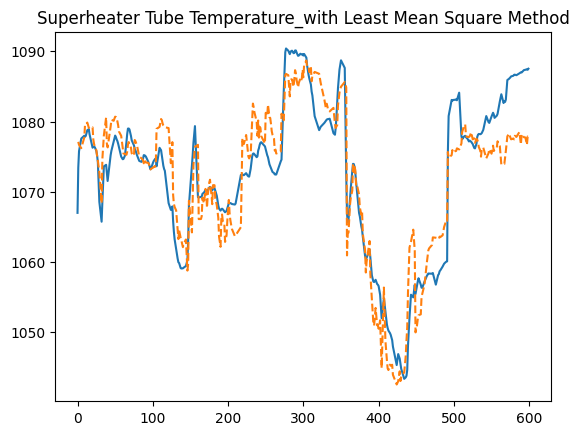

In [17]:
plt.figure(1)
plt.plot(tr_steps, (32 + dsr_t_v[:, 0] * 9 / 5))
plt.plot(tr_steps[1:], (32 + ynn_t_v[:-1, 0] * 9 / 5), '--')
plt.title('Superheater Outlet Flue Gas Temperature_with Least Mean Square Method')

plt.figure(2)
plt.plot(tr_steps, (32 + dsr_t_v[:, 1] * 9 / 5))
plt.plot(tr_steps[1:], (32 + ynn_t_v[:-1, 1] * 9 / 5), '--')
plt.title('Superheater Steam Outlet Temperature_with Least Mean Square Method')

plt.figure(3)
plt.plot(tr_steps, (32 + dsr_t_v[:, 2] * 9 / 5))
plt.plot(tr_steps[1:], (32 + ynn_t_v[:-1, 2] * 9 / 5), '--')
plt.title('Superheater Tube Temperature_with Least Mean Square Method')
plt.show()

In [18]:
# Calculation of RMSE for Training Plots
rmse_flue_gas_t = np.sqrt(np.mean((dsr_t_v[:, 0] - ynn_t_v[:, 0])**2))
rmse_steam_t = np.sqrt(np.mean((dsr_t_v[:, 1] - ynn_t_v[:, 1])**2))
rmse_tube_t = np.sqrt(np.mean((dsr_t_v[:, 2] - ynn_t_v[:, 2])**2))

In [19]:
(rmse_flue_gas_t+rmse_steam_t+rmse_tube_t)/3

2.2735511552541534

#Validation

In [20]:
Dv = np.zeros((tc, tv))
for i in range(tc):
    for j in range(tv):
        Dv[i, j] = np.linalg.norm(centermat[:, i] - Imat_v[:, j])
yHL = 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-Dv**2 / (2 * sigma**2))
ynn_v = np.dot(yHL.T, z)
dsr_v_p = dsr_v.T * delta[ni:] + np.min(data[:, ni:], axis=0)
ynn_v_p = ynn_v * delta[ni:] + np.min(data[:, ni:], axis=0)

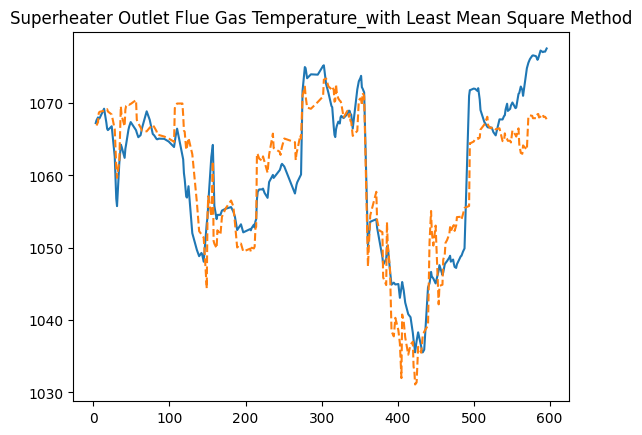

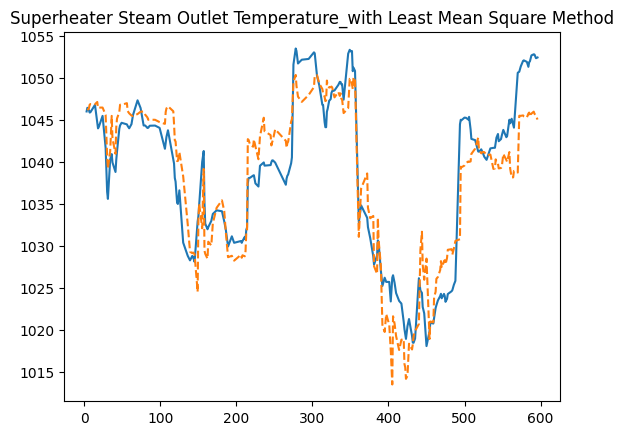

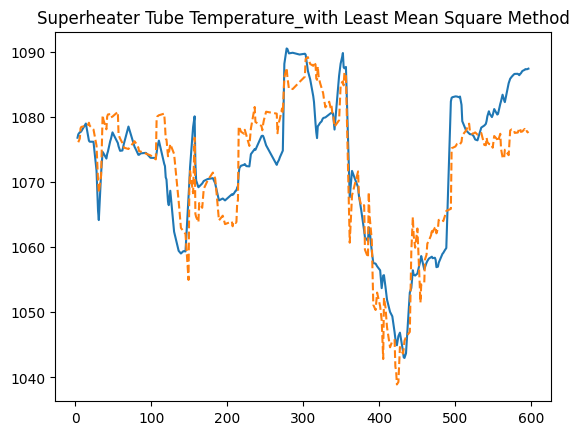

In [21]:
plt.figure(4)
plt.plot(val_steps, (32 + dsr_v_p[:, 0] * 9 / 5))
plt.plot(val_steps[1:], (32 + ynn_v_p[:-1, 0] * 9 / 5), '--')
plt.title('Superheater Outlet Flue Gas Temperature_with Least Mean Square Method')

plt.figure(5)
plt.plot(val_steps, (32 + dsr_v_p[:, 1] * 9 / 5))
plt.plot(val_steps[1:], (32 + ynn_v_p[:-1, 1] * 9 / 5), '--')
plt.title('Superheater Steam Outlet Temperature_with Least Mean Square Method')

plt.figure(6)
plt.plot(val_steps, (32 + dsr_v_p[:, 2] * 9 / 5))
plt.plot(val_steps[1:], (32 + ynn_v_p[:-1, 2] * 9 / 5), '--')
plt.title('Superheater Tube Temperature_with Least Mean Square Method')
plt.show()

In [22]:
# Calculation of RMSE for Validation Plots
rmse_flue_gas = np.sqrt(np.mean((dsr_v_p[:, 0] - ynn_v_p[:, 0])**2))
rmse_steam = np.sqrt(np.mean((dsr_v_p[:, 1] - ynn_v_p[:, 1])**2))
rmse_tube = np.sqrt(np.mean((dsr_v_p[:, 2] - ynn_v_p[:, 2])**2))

In [23]:
(rmse_flue_gas+rmse_steam+rmse_tube)/3

2.666242973610014